In [1]:
# Ramsey King
# DSC 550 - Data Mining
# November 7, 2021
# Exercise 9.3

In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

data = pd.read_json('categorized-comments.jsonl', lines=True)
data.head(1)
data.shape



(606476, 2)

In [3]:
category_list = list(set(data['cat']))
category_list

['sports', 'science_and_technology', 'video_games']

In [4]:
def make_categorical(corpus_cat):
    cat_dictionary = {
        'science_and_technology': 1,
        'sports': 2,
        'video_games': 3,
    }

    return cat_dictionary.get(corpus_cat)

data['cat_num'] = data['cat'].apply(make_categorical)


1. Neural Network Classifier with Scikit

Using the multi-label classifier dataset (categorized-comments.jsonl), fit a neural network classifier using scikit-learn to predict the comment category. Use the code found in chapter 12 of the Applied Text Analysis with Python book as a guide, but you will need to modify the code for this dataset. Report the accuracy, precision, recall, F1-score, and confusion matrix.

In [5]:
stemmer = SnowballStemmer('english')
stop_words = stopwords.words('english')

data['processed_text'] = data['txt'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub('[^a-zA-Z]', " ", x).split() if i not in stop_words]).lower())
data['processed_text'][0]

'bare better gabbert he signific better year he th passer rate ahead guy like philip river carson palmer eli man tyrod taylor and worst surround offens cast leagu he without doubt better career backup list although jimmi g could potenti better riski kaep especi get one cheap year anyway still get rid much acquir'

We will get the scores required to satsify the exercise requirements:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data['processed_text'], data.cat_num, test_size=0.2)

pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,2), stop_words='english', sublinear_tf=True)),
('chi', SelectKBest(chi2, k=10000)),
('clf', LinearSVC(C=1.0, penalty='l1', max_iter=3000, dual=False))
])

model = pipeline.fit(X_train, y_train)
predicted_values = model.predict(X_train)

vectorizer = model.named_steps['vect']
chi = model.named_steps['chi']
clf = model.named_steps['clf']

feature_names = vectorizer.get_feature_names_out()
feature_names = [feature_names[i] for i in chi.get_support(indices=True)]
feature_names = np.asarray(feature_names)

target_names = ['1', '2', '3']

print("Top 10 keywords per class: ")
for i, label in enumerate(target_names):
    top10 = np.argsort(clf.coef_[i])[-10:]
    print('%s: %s' % (label, " ".join(feature_names[top10])))



print("accuracy score: " + str(model.score(X_test, y_test)))
print("f1_score: " + str(f1_score(y_train, predicted_values, average='macro')))
print("recall: " + str(recall_score(y_train, predicted_values, average='macro')))
print("precision: " + str(precision_score(y_train, predicted_values, average='macro')))
print(str(confusion_matrix(y_train, predicted_values)))





Top 10 keywords per class: 
1: snapdragon xda textra xiaomi moto rcs nougat allo whatsapp bootloop
2: wicket clemson sif futbin tailgat wl otw klopp sbc cfb
3: ld bungi mt blizzard rubi dota clan mmr nintendo mut
accuracy score: 0.8564585806621817
f1_score: 0.7741979191301952
recall: 0.7091352800859054
precision: 0.8958974149518294
[[ 11944    160   8031]
 [   113  64467  51968]
 [   927   5669 341901]]


In [7]:
# f1_score
print("f1_score: " + str(f1_score(y_train, predicted_values, average='macro')))

f1_score: 0.7741979191301952


In [8]:
# recall score
print("recall: " + str(recall_score(y_train, predicted_values, average='macro')))


recall: 0.7091352800859054


In [9]:
# precision
print("precision: " + str(precision_score(y_train, predicted_values, average='macro')))


precision: 0.8958974149518294


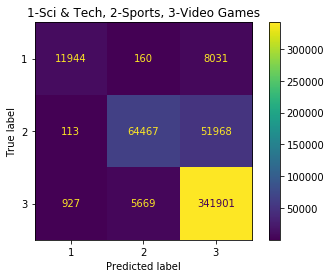

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_train, predicted_values, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.title("1-Sci & Tech, 2-Sports, 3-Video Games")
plt.show()

2. Neural Network Classifier with Keras
Using the multi-label classifier dataset (categorized-comments.jsonl), fit a neural network classifier with Keras to predict the comment category. Use the code found in chapter 12 of the Applied Text Analysis with Python book as a guide, but you will need to modify the code for this dataset. Report the accuracy, precision, recall, F1-score, and confusion matrix.

In [13]:
import keras
print('# of training samples: {}'.format(len(X_train)))
print('# of test samples: {}'.format(len(X_test)))

num_classes = max(y_train)
print('# of classes: {}'.format(num_classes))

# of training samples: 485180
# of test samples: 121296
# of classes: 3


In [16]:
from collections import Counter

# count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(data.processed_text)

In [17]:
len(counter)

98824

In [23]:
counter.most_common(5)
num_unique_words = len(counter)

In [24]:
train_size = int(data.shape[0]*0.8)
train_df = data[:train_size]
val_df = data[train_size:]

# split text and labels

train_sentences = train_df.processed_text.to_numpy()
train_label = train_df.cat_num.to_numpy()
val_sentences = val_df.processed_text.to_numpy()
val_labels = val_df.cat_num.to_numpy()

In [25]:
train_sentences.shape, val_sentences.shape

((485180,), (121296,))

In [26]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences)

In [27]:
word_index = tokenizer.word_index

In [28]:
word_index

{'i': 1,
 'game': 2,
 'like': 3,
 'get': 4,
 'play': 5,
 'one': 6,
 'would': 7,
 'it': 8,
 'the': 9,
 'use': 10,
 'think': 11,
 'go': 12,
 'time': 13,
 'peopl': 14,
 'make': 15,
 'good': 16,
 'if': 17,
 'com': 18,
 'realli': 19,
 'player': 20,
 'even': 21,
 'you': 22,
 'switch': 23,
 'know': 24,
 'want': 25,
 'see': 26,
 'also': 27,
 'still': 28,
 'much': 29,
 'look': 30,
 'that': 31,
 'say': 32,
 'team': 33,
 'well': 34,
 'need': 35,
 'got': 36,
 'thing': 37,
 'year': 38,
 'https': 39,
 'post': 40,
 'gt': 41,
 'could': 42,
 'tri': 43,
 'way': 44,
 'work': 45,
 'better': 46,
 'k': 47,
 'remov': 48,
 'delet': 49,
 'new': 50,
 'this': 51,
 'back': 52,
 'first': 53,
 'www': 54,
 'actual': 55,
 'r': 56,
 'right': 57,
 'take': 58,
 'though': 59,
 'lot': 60,
 'but': 61,
 'day': 62,
 'nintendo': 63,
 'they': 64,
 'come': 65,
 'sure': 66,
 'thank': 67,
 'never': 68,
 'and': 69,
 'feel': 70,
 'pretti': 71,
 'point': 72,
 'buy': 73,
 'he': 74,
 'question': 75,
 'someth': 76,
 'best': 77,
 'http'

In [29]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [30]:
print(train_sentences[10:15])
print(train_sequences[10:15])

['familiar system i guy higher' 'so basic alex smith deal' 'whi'
 'agre i care anyon say pay much guy he matt flynn written' '']
[[2414, 157, 1, 98, 513], [88, 274, 3725, 1552, 389], [260], [204, 1, 285, 227, 32, 271, 29, 98, 74, 2960, 18943, 2208], []]


In [31]:
# pad sequences to have same length

from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 20

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating='post')
train_padded.shape, val_padded.shape

((485180, 20), (121296, 20))

In [32]:
train_padded[10]

array([2414,  157,    1,   98,  513,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [33]:
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])
reverse_word_index

{1: 'i',
 2: 'game',
 3: 'like',
 4: 'get',
 5: 'play',
 6: 'one',
 7: 'would',
 8: 'it',
 9: 'the',
 10: 'use',
 11: 'think',
 12: 'go',
 13: 'time',
 14: 'peopl',
 15: 'make',
 16: 'good',
 17: 'if',
 18: 'com',
 19: 'realli',
 20: 'player',
 21: 'even',
 22: 'you',
 23: 'switch',
 24: 'know',
 25: 'want',
 26: 'see',
 27: 'also',
 28: 'still',
 29: 'much',
 30: 'look',
 31: 'that',
 32: 'say',
 33: 'team',
 34: 'well',
 35: 'need',
 36: 'got',
 37: 'thing',
 38: 'year',
 39: 'https',
 40: 'post',
 41: 'gt',
 42: 'could',
 43: 'tri',
 44: 'way',
 45: 'work',
 46: 'better',
 47: 'k',
 48: 'remov',
 49: 'delet',
 50: 'new',
 51: 'this',
 52: 'back',
 53: 'first',
 54: 'www',
 55: 'actual',
 56: 'r',
 57: 'right',
 58: 'take',
 59: 'though',
 60: 'lot',
 61: 'but',
 62: 'day',
 63: 'nintendo',
 64: 'they',
 65: 'come',
 66: 'sure',
 67: 'thank',
 68: 'never',
 69: 'and',
 70: 'feel',
 71: 'pretti',
 72: 'point',
 73: 'buy',
 74: 'he',
 75: 'question',
 76: 'someth',
 77: 'best',
 78: 'h

In [34]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx,"?") for idx in sequence])
decoded_text = decode(train_sequences[10])
print(train_sequences[10])
print(decoded_text)

[2414, 157, 1, 98, 513]
familiar system i guy higher


In [35]:
# Create LSTM model
from tensorflow.keras import layers
model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

model.add(layers.LSTM(64, dropout=0.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            3162368   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 3,187,265
Trainable params: 3,187,265
Non-trainable params: 0
_________________________________________________________________


In [47]:
import tensorflow
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [50]:
model.fit(train_padded, train_label, epochs=2, validation_data=(val_padded, val_labels), verbose=2)

Epoch 1/2
15162/15162 - 559s - loss: -1.4687e+04 - accuracy: 0.0518 - val_loss: -1.9389e+04 - val_accuracy: 0.0000e+00 - 559s/epoch - 37ms/step
Epoch 2/2
15162/15162 - 621s - loss: -1.6257e+04 - accuracy: 0.0518 - val_loss: -2.1357e+04 - val_accuracy: 0.0000e+00 - 621s/epoch - 41ms/step


In [52]:
predictions = model.predict(train_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

In [53]:
print(train_sentences[10:20])
print(train_label[10:20])
print(predictions[10:20])

['familiar system i guy higher' 'so basic alex smith deal' 'whi'
 'agre i care anyon say pay much guy he matt flynn written' ''
 'nobodi woulda sign free agent part w two first round pick'
 'i believ upvot' 'i wrote let know guy want see next' 'delet'
 'i agre complet especi silicon valley thing niner look like lead leagu analyt']
[2 2 2 2 2 2 2 2 2 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
TP = tensorflow.count_nonzero(predicted * actual)
TN = tensorflow.count_nonzero((predicted - 1) * (actual - 1))
FP = tensorflow.count_nonzero(predicted * (actual - 1))
FN = tensorflow.count_nonzero((predicted - 1) * actual)